# 作業 : (Kaggle)鐵達尼生存預測
https://www.kaggle.com/c/titanic

# [作業目標]
- 試著調整特徵篩選的門檻值, 觀察會有什麼影響效果

# [作業重點]
- 調整相關係數過濾法的篩選門檻, 看看篩選結果的影響 (In[5]~In[8], Out[5]~Out[8])
- 調整L1 嵌入法篩選門檻, 看看篩選結果的影響 (In[9]~In[11], Out[9]~Out[11])

In [5]:
# 做完特徵工程前的所有準備 (與前範例相同)
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

data_path = '/content/drive/MyDrive/資料科學/第四屆基機器學習馬拉松/D30/'
X_train = pd.read_csv(data_path + 'titanic_train.csv')

y_train = X_train['Survived']
X_train = X_train.drop(['PassengerId', 'Survived'] , axis=1)
X_train.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# 瞭解目前特徵的類型
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Name      891 non-null    object 
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Ticket    891 non-null    object 
 7   Fare      891 non-null    float64
 8   Cabin     204 non-null    object 
 9   Embarked  889 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 69.7+ KB


共有11特徵，初步看到總共有891筆資料
* 數值型特徵: Age、SibSp、Parch、Fare
* 類別型特徵: Name、Sex、Ticket、Cabin、Embarked、Pclass(已經變成數值的類別型特徵)
* 有遺漏值的特徵:Age、Cabin(遺漏大部分)、Embarked

* Age有需要分組嗎?
* SibSp、Parch、Fare都需要去偏態
* 

In [8]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


在描述性統計中，跑出結果的都是數值型特徵，而這些特徵需要做特徵縮放

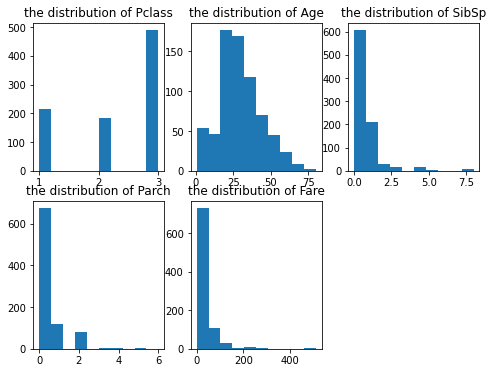

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
num_feature = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
nrow = 2
ncol = 3
for i, feature in zip(range(len(num_feature)), num_feature):
  plt.subplot(nrow, ncol, i+1)
  plt.hist(X_train[feature])
  plt.title('the distribution of {}'.format(feature))
plt.show()

In [20]:
X_train['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [21]:
# Name

X_train['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

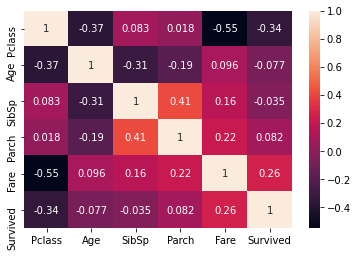

In [24]:
# 計算df整體相關係數, 並繪製成熱圖 (僅有數值型特徵能與目標做相關性分析)
import seaborn as sns
import matplotlib.pyplot as plt
df = X_train.join(y_train)
corr = df.corr()
sns.heatmap(corr, annot=True)
plt.show()

# 僅有Pclass、Fare與存活與否有低相關性，其他數值型特徵相關性極低

In [26]:
#只取 int64, float64 兩種數值型欄位, 存於 num_features 中
num_features = []
for dtype, feature in zip(X_train.dtypes, X_train.columns):
    if dtype == 'float64' or dtype == 'int64':
        num_features.append(feature)
print(f'{len(num_features)} Numeric Features : {num_features}\n')

# 削減文字型欄位, 只剩數值型欄位，並將遺漏值以-1填補
X_train = X_train[num_features]
X_train = X_train.fillna(-1)
MMEncoder = MinMaxScaler()
X_train.head()

5 Numeric Features : ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']



,Pclass,Age,SibSp,Parch,Fare
0,3,22.0,1,0,7.2500
1,1,38.0,1,0,71.2833
2,3,26.0,0,0,7.9250
3,1,35.0,1,0,53.1000
4,3,35.0,0,0,8.0500


# 作業1
* 鐵達尼生存率預測中，試著變更兩種以上的相關係數門檻值，觀察預測能力是否提升?

In [27]:
# 原始特徵 + 邏輯斯迴歸
train_X = MMEncoder.fit_transform(X_train)
estimator = LogisticRegression()
cross_val_score(estimator, train_X, y_train, cv=5).mean()

0.70041428661101

In [34]:
# 篩選相關係數1 設定高於0.2相關係數的會留下
high_list = df.columns[df.corr()['Survived'].abs()>0.2]
high_list = high_list.drop('Survived')
print(high_list)

Index(['Pclass', 'Fare'], dtype='object')


In [35]:
# 特徵1 + 邏輯斯迴歸
train_X = MMEncoder.fit_transform(df[high_list])
cross_val_score(estimator, train_X, y_train, cv=5).mean()

0.6790973573535873

In [37]:
# 篩選相關係數2
"""
Your Code Here
"""
high_list = df.columns[df.corr()['Survived'].abs()>0.05]
high_list = high_list.drop('Survived')
print(high_list)

Index(['Pclass', 'Parch', 'Fare'], dtype='object')


In [38]:
# 特徵2 + 邏輯斯迴歸
train_X = MMEncoder.fit_transform(df[high_list])
cross_val_score(estimator, train_X, y_train, cv=5).mean()

0.6858263762475676

並無提升，反倒刪掉一些相關係數較為小的特徵後，其準確率有稍微下降，且相關係數門檻設得越高，其刪掉的特徵越多，準確率越低，可能刪掉了一些資訊讓模型擬合效果下降

# 作業2
* 續上題，使用 L1 Embedding 做特徵選擇(自訂門檻)，觀察預測能力是否提升?

In [45]:
from sklearn.linear_model import Lasso
"""
Your Code Here, select parameter alpha 
"""
L1_Reg = Lasso(alpha=0.01)
train_X = MMEncoder.fit_transform(X_train)
L1_Reg.fit(train_X, y_train)
L1_Reg.coef_

array([-0.33670344, -0.        , -0.        ,  0.        ,  0.        ])

In [46]:
from itertools import compress
L1_mask = list((L1_Reg.coef_>0) | (L1_Reg.coef_<0))
L1_list = list(compress(list(df), list(L1_mask)))
L1_list

['Pclass']

In [47]:
# L1_Embedding 特徵 + 線性迴歸
train_X = MMEncoder.fit_transform(df[L1_list])
cross_val_score(estimator, train_X, y_train, cv=5).mean()

0.6790973573535873